In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from agents import *
from tqdm.auto import tqdm
from environments import RaceTrack
from IPython.display import Image
from multiproc_utils import TrainPool

In [2]:
track = RaceTrack(RaceTrack.track_challenge)
track.set_eval()

#n = 5
alpha = 0.5
epsilon = 0.1
final_alpha = 0.0
final_epsilon = 0.0
selector = EpsilonGreedy(epsilon=epsilon)

alpha_schedule = SigmoidSchedule(
    ["learner", "alpha"],
    alpha,
    0.0,
)
epsilon_schedule = LinearSchedule(
    ["selector", "epsilon"],
    epsilon,
    final_epsilon,
)

In [3]:
learner = NStepTreeBackup(n=2, alpha=alpha)
tb2_agent = Agent(
    num_states=track.num_states,
    num_actions=track.num_actions,
    selector=selector,
    learner=learner,
    schedules=[
        alpha_schedule,
        epsilon_schedule,
    ],
)

learner = NStepTreeBackup(n=3, alpha=alpha)
tb3_agent = Agent(
    num_states=track.num_states,
    num_actions=track.num_actions,
    selector=selector,
    learner=learner,
    schedules=[
        alpha_schedule,
        epsilon_schedule,
    ],
)

In [4]:
num_episodes = 10_000
num_runs = 5

pool = TrainPool([tb2_agent, tb3_agent], track, quiet=True)
tb2_agent, tb3_agent = pool.train_average(num_episodes, num_runs)

Training Runs:   0%|          | 0/5 [00:00<?, ?it/s]

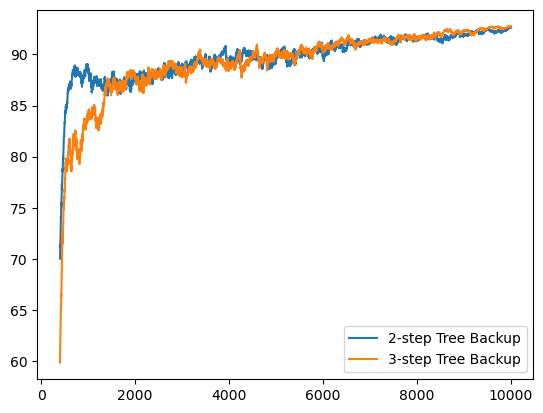

In [13]:
trail_length = 70
start_from = 400

for agent, name in [
    (tb2_agent, "2-step Tree Backup"), (tb3_agent, "3-step Tree Backup")
     ]:
    xs, ys = agent.smoothed_ep_returns(trail_length)
    plt.plot(xs[start_from:], ys[start_from:], label=name)
    
plt.legend()
plt.show()

In [10]:
import agents

from itertools import product


def agent_combinations(
    num_states: int,
    num_actions: int,
    selectors: list[agents.ActionSelector],
    learners: list[agents.UpdateMethod],
    scheduless: list[list[agents.Schedule]],
    planners: list[agents.UpdateMethod],
):
    param_space = product(selectors, learners, scheduless, planners)

    agents = [
        Agent(
            num_states=num_states,
            num_actions=num_actions,
            selector=selector,
            learner=learner,
            schedules=schedules,
            planner=planner,
        ) for (selector, learner, schedules, planner) in param_space
    ]

    return agents

In [13]:
num_states = 2
num_actions = 2
selectors = [agents.EpsilonGreedy(0.2), agents.Greedy()]
learners = [agents.QLearning(0.5), agents.ExpectedSarsa(0.5)]
scheduless = [[]]
planners = [agents.Dyna(1, agents.EpsilonGreedy(0.2), agents.QLearning(0.5))]

agents = agent_combinations(num_states, num_actions, selectors, learners, scheduless, planners)
agents

[Agent(num_states=2, num_actions=2, Q=array([[0., 0.],
        [0., 0.]]), selector=EpsilonGreedy(epsilon=0.2, rng=Generator(PCG64) at 0x78B080479000), learner=QLearning(alpha=0.5, gamma=1.0), schedules=[], planner=Dyna(plan_steps=1, selector=EpsilonGreedy(epsilon=0.2, rng=Generator(PCG64) at 0x78B080478C80), learner=QLearning(alpha=0.5, gamma=1.0), plus=False, kappa=0.01, model={}, last_used_a=None, rng=Generator(PCG64) at 0x78B080479380), ep_lengths=[], ep_returns=[]),
 Agent(num_states=2, num_actions=2, Q=array([[0., 0.],
        [0., 0.]]), selector=EpsilonGreedy(epsilon=0.2, rng=Generator(PCG64) at 0x78B080479000), learner=ExpectedSarsa(alpha=0.5, gamma=1.0), schedules=[], planner=Dyna(plan_steps=1, selector=EpsilonGreedy(epsilon=0.2, rng=Generator(PCG64) at 0x78B080478C80), learner=QLearning(alpha=0.5, gamma=1.0), plus=False, kappa=0.01, model={}, last_used_a=None, rng=Generator(PCG64) at 0x78B080479380), ep_lengths=[], ep_returns=[]),
 Agent(num_states=2, num_actions=2, Q=array(

In [6]:
def get_returns(num_episodes):
    learner = NStepTreeBackup(n=2, alpha=alpha)
    tb2_agent = Agent(
        num_states=track.num_states,
        num_actions=track.num_actions,
        selector=selector,
        learner=learner,
        schedules=[
            alpha_schedule,
            epsilon_schedule,
        ],
    )
    
    learner = NStepTreeBackup(n=3, alpha=alpha)
    tb3_agent = Agent(
        num_states=track.num_states,
        num_actions=track.num_actions,
        selector=selector,
        learner=learner,
        schedules=[
            alpha_schedule,
            epsilon_schedule,
        ],
    )
    
    pool = TrainPool([tb2_agent, tb3_agent], track, quiet=True)
    tb2_agent, tb3_agent = pool.train(num_episodes)
    
    trail_length = 70
    xs1, ys1 = tb2_agent.smoothed_ep_returns(trail_length)
    xs2, ys2 = tb3_agent.smoothed_ep_returns(trail_length)

    return xs1, ys1, xs2, ys2

  0%|          | 0/100 [00:00<?, ?it/s]

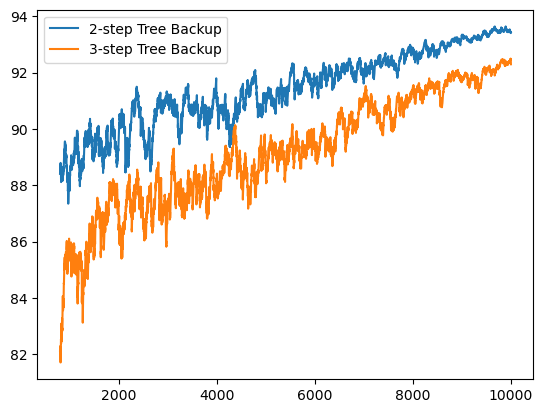

In [7]:
num_episodes = 10_000
num_train_runs = 100

xs = np.arange(num_episodes)
ys1_total = np.zeros((num_train_runs, num_episodes))
ys2_total = np.zeros((num_train_runs, num_episodes))

for i in tqdm(range(num_train_runs)):
    _, ys1, _, ys2 = get_returns(num_episodes)
    ys1_total[i, :] = ys1
    ys2_total[i, :] = ys2

ys1 = np.average(ys1_total, 0)
ys2 = np.average(ys2_total, 0)

start_from = 800

plt.plot(xs[start_from:], ys1[start_from:], label=f"2-step Tree Backup")
plt.plot(xs[start_from:], ys2[start_from:], label=f"3-step Tree Backup")

plt.legend()
plt.show()